# Computing Partial and Total Van Hove Function

This tutorial will go over the calculation of the Van Hove Function (VHF) using the scattering package. The VHF is defined as the time-dependent radial distribution function (RDF), $G(r, t)$ where $r$ is distance and $t$ is time. That is, the probability of finding particle $j$ at $t=t$ at a distance $r$ from the position of particle $i$ at $t=0$. The VHF analysis is useful as we can study the correlations between particles over time.

The VHF is defined as the following for fluids containing monotonic atoms:
$$
     G(r,t) = \frac{1}{4\pi\rho N r^2}\sum_{i, j} \delta(r - |\boldsymbol{r_i    }(0) - \boldsymbol{r_j}(t)|)
$$

where $\rho$ is the average number density of atoms, $N$ is the number of atoms in the system, $r_j(t)$ is the position of the $j$th atom at time $t$ and $\delta(r)$ is the Dirac delta function.

For fluids of polyatomic molecules, the VHF is computed as a summation of the VHFs between atoms $\alpha$ and $\beta$, which are referred to the partial VHFs. This equation for a partial VHF is defined as:

$$
 G_{\alpha\beta}(r,t)  = \frac{V}{4\pi N_\alpha N_\beta r^2}
\sum_{i\in\{\alpha\}}\sum_{i\in\{\beta\}} \delta(r - |\boldsymbol{r_i}(0    ) -
 \boldsymbol{r_j}(t)|)
 $$
The total VHF for a fluid computed from the partial VHFs is then defined as:

$$
\begin{gathered}
G(r,t) = \sum_{\alpha=1}^{N_\alpha} \sum_{\beta=1}^{N_\beta} x_{\alpha}     x_{\beta} \bar{b}_{\alpha} \bar{b}_{\beta}G_{\alpha\beta}(r,t) \\
\end{gathered}
$$
where $x_{\beta}$ is the atomic fraction for species $\beta$,and $\bar{b}_{\alpha}$ is the form factor proportional to the number of electrons in species $\alpha$.

## The 'scattering' package

`scattering` uses `MDTraj` as the backend to load in simulation trajectories for computing the VHF. There are two main functions for computing the VHF. Distance calculations are computed with underlying C++ code for computational efficiency.

The partial VHF for two species can be computed with the `function van_hove.compute_partial_van_hove`. The total VHF for a polyatomic fluid can be computed with the function `van_hove.compute_van_hove`. This tutorial will cover both functions below.

## Two Methods of Calculating Total Van Hove

In this tutorial, two methods of computing total Van Hove functions shall be discussed. In the first example, the total Van Hove Function shall be calculated by computing partial Van Hove functions which can be passed through the function "vhf_from_pvhf" to compute the total Van Hove function. Although this method requires more lines of code, users are able to have higher control over the computation. Alternatively, users can compute total Van Hove using the function "compute_van_hove" with certain concessions.

Both methods shall use a rigid, classical 3-site model - SPC/E.

## MDTraj trajectory object.
The main data structure in MDTraj is the trajectory object, which contains the position information for all atoms and all frames of a simulation.

A trajectory can be initialized with the md.load() function.



In [45]:
import numpy as np
import mdtraj as md
from scattering.utils.io import get_fn

trj = md.load(get_fn('spce.xtc'), top=get_fn('spce.gro'))

## Computing Partial Van Hove

To compute Partial Van Hove, `van_hove.compute_partial_van_hove` should be imported. When using this function, user must pass the trajectory in which they wish to analyze and specify the two atom pairs in which they desire to calculate the partial van hove of. 

In this example, partial VHF of Oxygen and Oxygen shall be calculated. 

In [46]:
from scattering.van_hove import compute_partial_van_hove

chunk_length = 20
r, g_r_t = compute_partial_van_hove(trj=trj,
                                            chunk_length=chunk_length,
                                            selection1="name O",
                                            selection2="name O",)

100% (50 of 50) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Text(0, 0.5, 'g(r, t)')

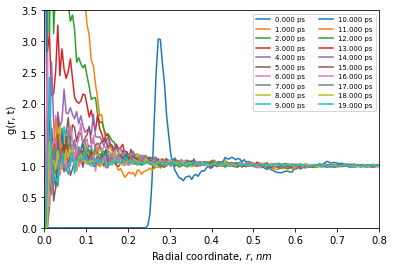

In [47]:
# plot the result with Matplotlib
import matplotlib.pyplot as plt


t = trj.time[:chunk_length+1]
for j in range(chunk_length):
    plt.plot(r, g_r_t[j], label='{:.3f} ps'.format(t[j]))

plt.xlim((0, 0.8))
plt.ylim((0, 3.5))

plt.legend(loc='upper right', bbox_to_anchor = (1,1), ncol = 2, fontsize = "x-small")
plt.xlabel(r'Radial coordinate, $r$, $nm$')
plt.ylabel("g(r, t)")



The above depicts the partial Van Hove function of Oxygen and Oxygen from $r = (0,0.8)$ nm. Note that the noise of the graph arises from insufficient trajectory chunk size. For a smoother curve, trajectories with higher chunk_length should be used. 

In the case where the user wants to define the specific atoms from speicifc molecules when calculating pvhf, user should follow the same atom name as written in the gro file. 

## Computing Total Van Hove from Partial Van Hove

Now that we know how to calculate Partial Van Hove functions, let's discuss adding each partials up to determine the Total Van Hove function.

Keep in mind that the total VHF for a fluid computed from the partial VHFs is then defined as:

$$
\begin{gathered}
G(r,t) = \sum_{\alpha=1}^{N_\alpha} \sum_{\beta=1}^{N_\beta} x_{\alpha}     x_{\beta} \bar{b}_{\alpha} \bar{b}_{\beta}G_{\alpha\beta}(r,t) \\
\end{gathered}
$$
where $x_{\beta}$ is the atomic fraction for species $\beta$,and $\bar{b}_{\alpha}$ is the form factor proportional to the number of electrons in species $\alpha$.

In previous versions of this pacakge, users were required to determine form factor for each atom when `water = False`. In this pacakge, the function `vhf_from_pvhf` should allow users to pass through a dictionary of partial van hove functions and recieve normalized total vhf with form factors accounted for. 


Similar to the previous version of the package, the form factor is estimated as the atomic number for each atom when water=False (default setting). When water=True, specific form factors for the oxygen and hydrogen atoms of water will be specified as defined from the paper: https://pubmed.ncbi.nlm.nih.gov/29291242/


To utilize `vhf_from_pvhf` several things must be passed:
* `trj` = trajectory on whivh partial vhf were calculated from
* `partial_dict` = dictionary containing partial vhf as np.array where the dictionary keys are tuples of length 2 with 2 atom names
* `element_dict` = dictionary containing element names corresponding to the atom name. Atom names shall be keys. 

Let's set up to utilize `vhf_from_pvhf`:

In [58]:
from itertools import combinations_with_replacement

#obtaining element dictionaries with element name values and corresponding atom name keys
element_dict = {}
for atom in trj.topology.atoms:
    element_dict[atom.name] = atom.element.symbol

# obtating pvhf dict of np.array as values and atom name as keys
partial_dict = {}
atom_names = set([atom.name for atom in trj.topology.atoms])
tuples_combination = combinations_with_replacement(atom_names, 2)

for pairs in tuples_combination:
    pair1 = pairs[0]
    pair2 = pairs[1]
    # Set in alphabetical order
    if pairs[0] > pairs[1]:
        pair2 = pairs[0]
        pair1 = pairs[1]

    r_pgrt, pgrt = compute_partial_van_hove(trj, chunk_length=chunk_length, 
                                 selection1=f"name {pair1}", selection2=f"name {pair2}")
    partial_dict[pairs] = pgrt[1]

100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
/Users/nahyeonkim/Desktop/scattering_packages/scattering/scattering/van_hove.py:252: UserWarning: Partial VHF calculation: No self-correlations for name H and name O, setting `self_correlation` to `False`.
  selection1, selection2
100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (50 of 50) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


We have obtained `element_dict`, `trj`, and `partial_dict`. Now, using `vhf_from_pvhf` users can calculate total VHF. In addition, take a moment to notice the format of `partial_dict` keys and `element_dict`.

In [49]:
from scattering.van_hove import vhf_from_pvhf

total_grt = vhf_from_pvhf(trj, partial_dict, element_dict)

print(f"partial_dict: \n {partial_dict.keys()}")

print(f"element_dict: \n {element_dict}")

partial_dict: 
 dict_keys([('H', 'H'), ('H', 'O'), ('O', 'O')])
element_dict: 
 {'O': 'O', 'H': 'H'}


/Users/nahyeonkim/Desktop/scattering_packages/scattering/scattering/utils/constants.py:18: UserWarning: Estimating atomic form factor as atomic number
  warnings.warn('Estimating atomic form factor as atomic number')


Lastly, using the calculated total VHF, VHF was plotted against r. 

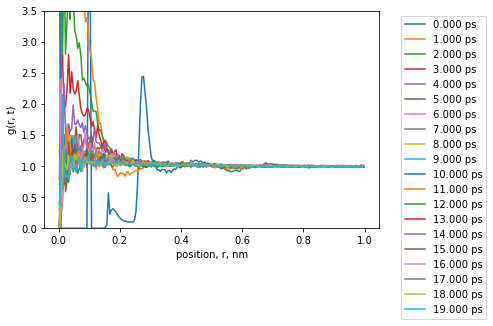

In [65]:
fig, ax = plt.subplots()

t = trj.time[:chunk_length+1]
for j in range(chunk_length):
    if j % 1 == 0:
        plt.plot(r_pgrt, total_grt[j], label='{:.3f} ps'.format(t[j]))

#plt.xlim((0, 0.8))
plt.ylim((0, 3.5))

plt.xlabel("position, r, nm")
plt.ylabel("g(r, t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('VHF from PVHF')
method_1_plot = fig

## Computing VHF from `compute_van_hove`

Another method to compute VHF is through `compute_van_hove` where the function calculates the partial VHFs `van_hove.compute_partial_van_hove` for each pairwise interaction and them sums them using the equation above for polyatomic fluids. The alogorithm closely follows the method mentioned previously where the user manually computes PVHF in order to sum them up to compute VHF. However, when using `compute_van_hove`, the user loses the ability to specify atoms in the molecule for pairwise interactions when there are more than 1 location of interest per element in the total system.

  4% (2 of 50) |#                        | Elapsed Time: 0:00:00 ETA:  00:00:00

doing oxygen and oxygen ...


100% (50 of 50) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
/Users/nahyeonkim/Desktop/scattering_packages/scattering/scattering/van_hove.py:127: UserWarning: Total VHF calculation: No self-correlations for oxygen and hydrogen, setting `self_correlation` to `False`.
  elem1, elem2
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

doing hydrogen and oxygen ...


100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

doing hydrogen and hydrogen ...


100% (50 of 50) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
/Users/nahyeonkim/Desktop/scattering_packages/scattering/scattering/utils/constants.py:18: UserWarning: Estimating atomic form factor as atomic number
  warnings.warn('Estimating atomic form factor as atomic number')


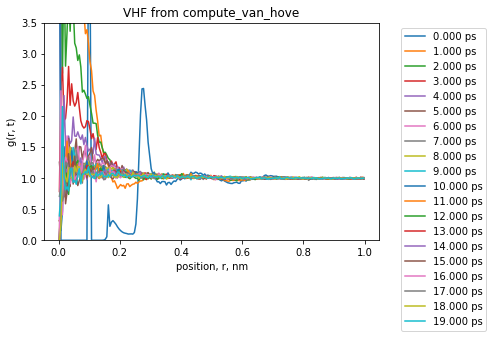

In [68]:
from scattering.van_hove import compute_van_hove
chunk_length = 20
r, t, g_r_t =compute_van_hove(trj=trj,chunk_length=chunk_length, water=False,)

fig, ax = plt.subplots()
for j in range(chunk_length):
    if j % 1 == 0:
        plt.plot(r, g_r_t[j], label='{:.3f} ps'.format(t[j]))

#plt.xlim((0, 0.8))
plt.ylim((0, 3.5))

plt.xlabel("position, r, nm")
plt.ylabel("g(r, t)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('VHF from compute_van_hove')
method_2_plot = fig

Note that in our system of just water, two methods yield the same data and subsequently the same plot. 

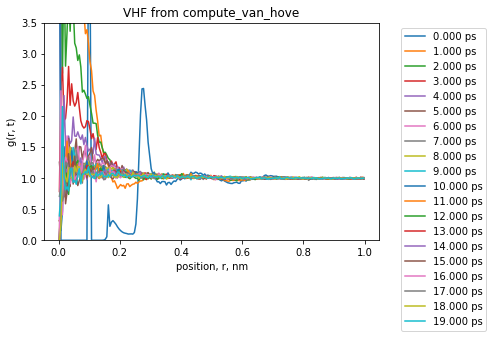

In [69]:


method_1_plot
method_2_plot